In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import openpyxl
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-v0_8-paper')
sns.set_palette("husl")

In [32]:
# Configuration
ALGORITHMS = ['NSGA-II', 'NSGA-III', 'SPEA2', 'ε-MOEA']
METRICS = ['hypervolume', 'spacing', 'diversity', 'convergence', 'execution_time']

# File paths
EXCEL_DIR = '../result/optimization results'
OUTPUT_DIR = '../result'

In [33]:
def load_all_datasets(excel_dir: str) -> pd.DataFrame:
    files = sorted([f for f in os.listdir(excel_dir) if f.endswith('.xlsx')])
    all_data = []
    
    metric_name_map = {
        'HYPERVOLUME': 'hypervolume',
        'SPACING': 'spacing',
        'DIVERSITY': 'diversity',
        'CONVERGENCE': 'convergence',
        'EXECUTION_TIME': 'execution_time'
    }
    
    for dataset_idx, filename in enumerate(files, 1):
        filepath = os.path.join(excel_dir, filename)
        wb = openpyxl.load_workbook(filepath, data_only=True)
        ws = wb['Raw Results']
        
        dataset_name = f"Dataset_{dataset_idx}"
        current_metric = None
        
        for row in ws.iter_rows(values_only=True):
            if row[0] and isinstance(row[0], str):
                upper_row = row[0].upper()
                if upper_row in metric_name_map:
                    current_metric = metric_name_map[upper_row]
                    continue
                
                if row[0] == 'Algorithm':
                    continue
                
                if current_metric and row[0] in ALGORITHMS:
                    algorithm = row[0]
                    for run_idx, value in enumerate(row[1:11], 1):  # Runs 1-10
                        if value is not None:
                            all_data.append({
                                'Algorithm': algorithm,
                                'Dataset': dataset_name,
                                'Dataset_ID': dataset_idx,
                                'Run': run_idx,
                                'Metric': current_metric,
                                'Value': float(value)
                            })
        
        wb.close()
    
    df = pd.DataFrame(all_data)
    return df

# Load data
data = load_all_datasets(EXCEL_DIR)

## TABLE 1: Overall Performance Comparison

In [34]:
from scipy import stats

def generate_table1_overall_performance(data: pd.DataFrame) -> pd.DataFrame:
    results = []
    
    for metric in METRICS:
        metric_data = data[data['Metric'] == metric]
        
        # Calculate mean ± SD for each algorithm
        row = {'Metric': metric.replace('_', ' ').title()}
        
        # Collect data for statistical test
        groups = []
        
        for algorithm in ALGORITHMS:
            subset = metric_data[metric_data['Algorithm'] == algorithm]['Value']
            mean = subset.mean()
            std = subset.std()
            
            # Format based on metric
            if metric == 'execution_time':
                row[algorithm] = f"{mean:.1f}±{std:.1f}"
            else:
                row[algorithm] = f"{mean:.3f}±{std:.3f}"
            
            groups.append(subset.values)
        
        # Kruskal-Wallis test (non-parametric ANOVA)
        h_stat, p_value = stats.kruskal(*groups)
        row['H-statistic'] = f"{h_stat:.3f}"
        row['p-value'] = "<0.001" if p_value < 0.001 else f"{p_value:.3f}"
        
        results.append(row)
    
    df = pd.DataFrame(results)
    return df


table1 = generate_table1_overall_performance(data)
print(table1.to_string(index=False))
table1.to_csv(os.path.join(OUTPUT_DIR, 'tables', 'table1_overall_performance.csv'), index=False)

        Metric     NSGA-II    NSGA-III       SPEA2      ε-MOEA H-statistic p-value
   Hypervolume 0.362±0.019 0.362±0.016 0.362±0.019 0.353±0.022      16.280  <0.001
       Spacing 0.459±0.367 0.419±0.285 0.518±0.341 0.671±0.389      32.970  <0.001
     Diversity 1.361±0.542 1.320±0.514 1.555±0.615 1.846±0.691      40.662  <0.001
   Convergence 0.693±0.386 0.655±0.340 1.065±0.572 0.940±0.514      49.643  <0.001
Execution Time  31.1±108.8  30.4±106.9   14.3±33.7 157.0±234.8     226.714  <0.001


## FIGURE 1: Performance Radar Chart

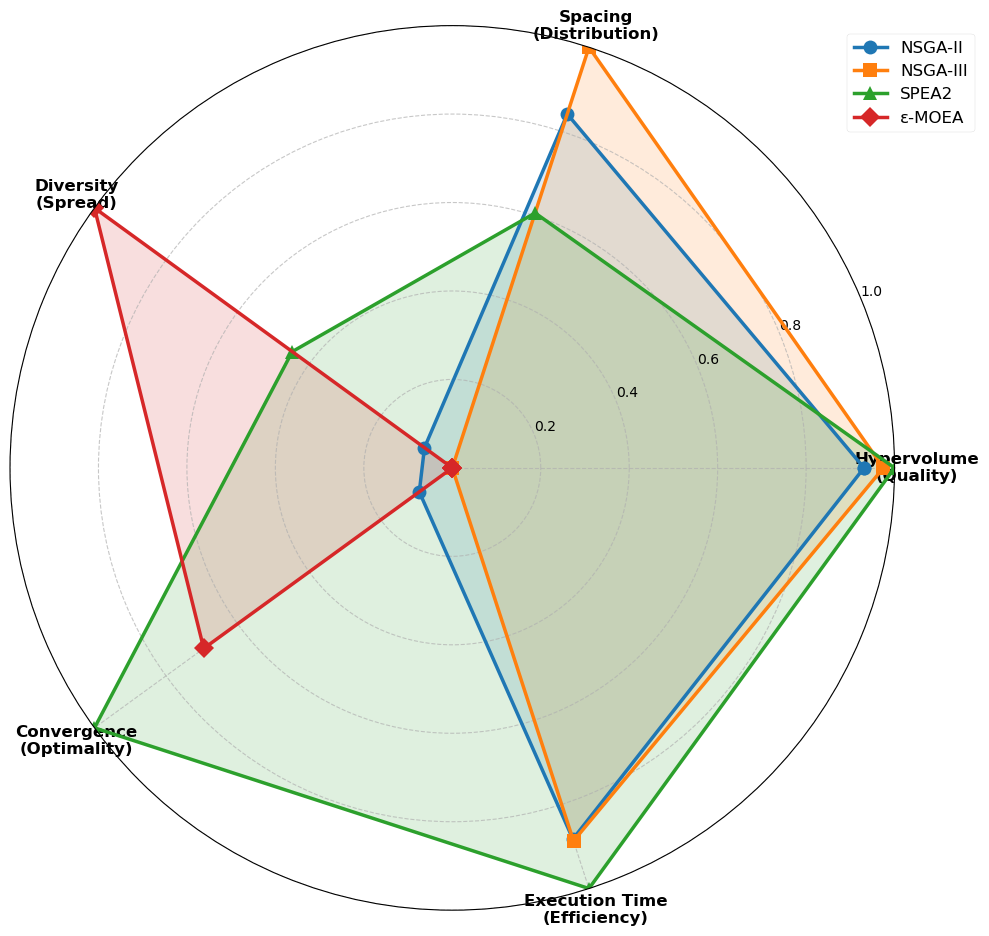

In [35]:
def create_radar_chart(data: pd.DataFrame, save_path: str = None):
    # Calculate mean performance for each algorithm-metric pair
    performance = {}
    for algorithm in ALGORITHMS:
        performance[algorithm] = []
        for metric in METRICS:
            subset = data[(data['Algorithm'] == algorithm) & (data['Metric'] == metric)]
            mean_val = subset['Value'].mean()
            performance[algorithm].append(mean_val)
    
    # Normalize to [0, 1] for each metric
    normalized = {alg: [] for alg in ALGORITHMS}
    
    for i, metric in enumerate(METRICS):
        values = [performance[alg][i] for alg in ALGORITHMS]
        min_val = min(values)
        max_val = max(values)
        
        # For execution_time and spacing, lower is better, so invert
        if metric in ['execution_time', 'spacing']:
            for alg in ALGORITHMS:
                norm_val = 1 - (performance[alg][i] - min_val) / (max_val - min_val) if max_val > min_val else 0.5
                normalized[alg].append(norm_val)
        else:
            for alg in ALGORITHMS:
                norm_val = (performance[alg][i] - min_val) / (max_val - min_val) if max_val > min_val else 0.5
                normalized[alg].append(norm_val)
    
    # Create radar chart
    angles = np.linspace(0, 2 * np.pi, len(METRICS), endpoint=False).tolist()
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    colors = {'NSGA-II': '#1f77b4', 'NSGA-III': '#ff7f0e', 
              'SPEA2': '#2ca02c', 'ε-MOEA': '#d62728'}
    markers = {'NSGA-II': 'o', 'NSGA-III': 's', 'SPEA2': '^', 'ε-MOEA': 'D'}
    
    for algorithm in ALGORITHMS:
        values = normalized[algorithm]
        values += values[:1]
        ax.plot(angles, values, 'o-', linewidth=2.5, label=algorithm,
               color=colors[algorithm], marker=markers[algorithm], markersize=10)
        ax.fill(angles, values, alpha=0.15, color=colors[algorithm])
    
    # Formatting
    metric_labels = ['Hypervolume\n(Quality)', 'Spacing\n(Distribution)', 
                    'Diversity\n(Spread)', 'Convergence\n(Optimality)', 
                    'Execution Time\n(Efficiency)']
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metric_labels, size=12, fontweight='bold')
    ax.set_ylim(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], size=10)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1), fontsize=12, framealpha=0.9)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')    
    return fig

create_radar_chart(data, os.path.join(OUTPUT_DIR, 'figures', 'figure1_radar_chart.png'))
plt.show()

## FIGURE S1: Box Plot Distributions

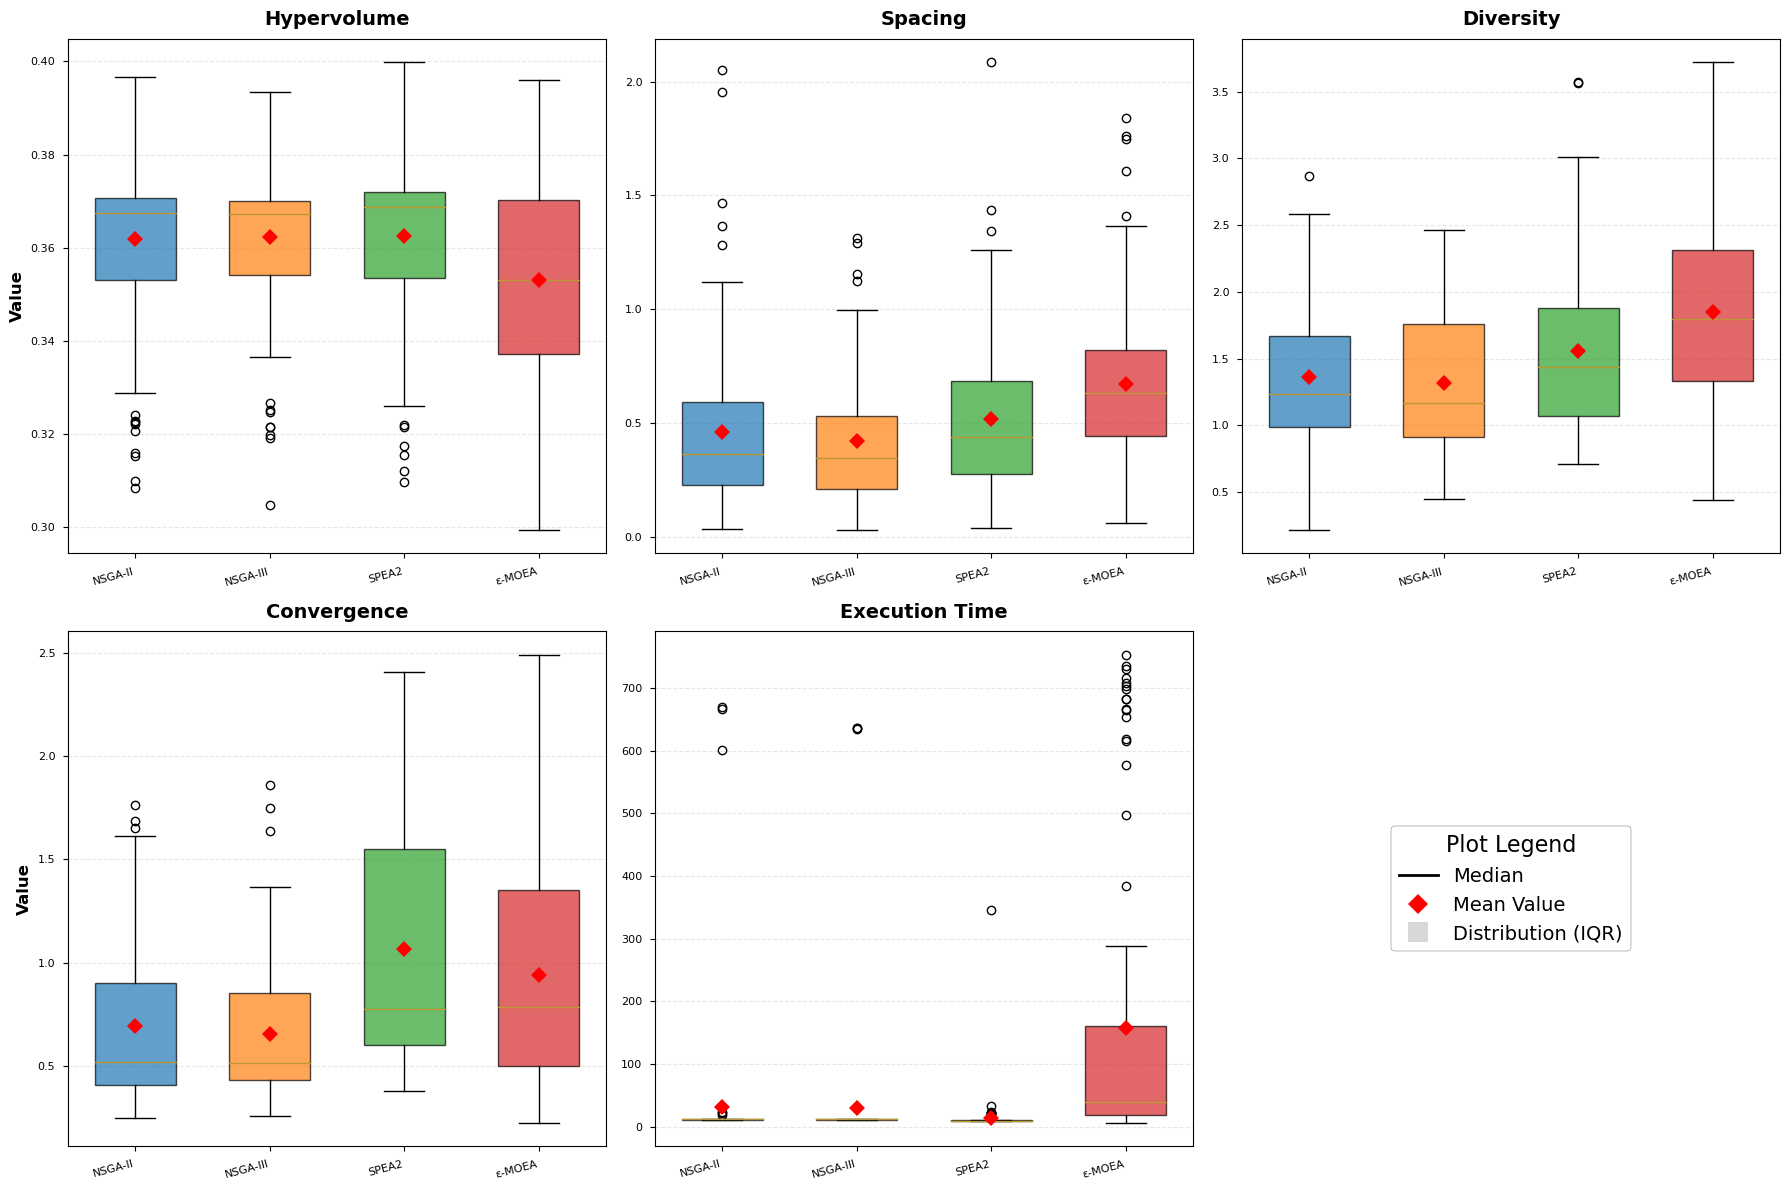

In [36]:
def plot_all_metrics_combined(data: pd.DataFrame, save_path: str = None):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
    axes = axes.flatten()  # 반복문을 돌리기 쉽게 1차원 배열로 변환
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    for i, metric in enumerate(METRICS):
        ax = axes[i]
        metric_data = data[data['Metric'] == metric]
        
        bp = ax.boxplot(
            [metric_data[metric_data['Algorithm'] == alg]['Value'].values for alg in ALGORITHMS],
            labels=ALGORITHMS,
            patch_artist=True,
            widths=0.6,
            showmeans=True,
            meanprops=dict(marker='D', markerfacecolor='red', markeredgecolor='black', markersize=8)
        )
        
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax.set_title(metric.replace('_', ' ').title(), fontsize=14, fontweight='bold', pad=10)
        ax.grid(True, alpha=0.3, axis='y', linestyle='--')
        
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=15, ha='right')
        if i % 3 == 0:
            ax.set_ylabel('Value', fontsize=12, fontweight='bold')
    
    last_ax = axes[5]
    last_ax.axis('off')  # 축 숨기기
    legend_elements = [
        plt.Line2D([0], [0], color='black', linewidth=2, label='Median'),
        plt.Line2D([0], [0], marker='D', color='w', markerfacecolor='red',
                  markeredgecolor='black', markersize=10, label='Mean Value'),
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='gray', 
                   alpha=0.3, markersize=15, label='Distribution (IQR)')
    ]
    last_ax.legend(handles=legend_elements, loc='center', fontsize=14, 
                   title='Plot Legend', title_fontsize=16, frameon=True, edgecolor='black')

    plt.tight_layout()
    
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    return fig

output_file = os.path.join(OUTPUT_DIR, 'figures', 'figure S1_all_metrics_boxplot.png')
fig_combined = plot_all_metrics_combined(data, output_file)
plt.show()

## TABLE2: Variance Decomposition

In [42]:
def calculate_icc(subset: pd.DataFrame) -> float:
    # Between-dataset variance
    dataset_means = subset.groupby('Dataset')['Value'].mean()
    between_var = dataset_means.var(ddof=1)
    
    # Within-dataset variance
    within_vars = []
    for dataset in subset['Dataset'].unique():
        dataset_data = subset[subset['Dataset'] == dataset]['Value']
        if len(dataset_data) > 1:
            within_vars.append(dataset_data.var(ddof=1))
    within_var = np.mean(within_vars) if within_vars else 0.0
    
    # Total variance
    total_var = subset['Value'].var(ddof=1)
    
    # ICC
    if total_var > 0:
        icc = between_var / total_var
        icc = max(0.0, min(1.0, icc))
    else:
        icc = 0.0
    
    return icc

def bootstrap_icc_ci(data: pd.DataFrame, algorithm: str, metric: str, n_bootstrap: int = 1000, confidence_level: float = 0.95, 
                     random_seed: int = 42) -> Tuple[float, float, float]:
    subset = data[(data['Algorithm'] == algorithm) & (data['Metric'] == metric)].copy()
    
    if len(subset) == 0:
        return 0.0, 0.0, 0.0
    
    # Calculate original ICC
    original_icc = calculate_icc(subset)
    
    # Bootstrap resampling
    np.random.seed(random_seed)
    bootstrap_iccs = []
    
    datasets = subset['Dataset'].unique()
    n_datasets = len(datasets)
    
    for _ in range(n_bootstrap):
        # Resample datasets with replacement
        bootstrap_datasets = np.random.choice(datasets, size=n_datasets, replace=True)
        
        # Create bootstrap sample
        bootstrap_sample = []
        for dataset in bootstrap_datasets:
            dataset_data = subset[subset['Dataset'] == dataset].copy()
            bootstrap_sample.append(dataset_data)
        
        bootstrap_df = pd.concat(bootstrap_sample, ignore_index=True)
        
        # Calculate ICC for this bootstrap sample
        bootstrap_icc = calculate_icc(bootstrap_df)
        bootstrap_iccs.append(bootstrap_icc)
    
    # Calculate confidence interval
    alpha = 1 - confidence_level
    lower_percentile = (alpha / 2) * 100
    upper_percentile = (1 - alpha / 2) * 100
    
    ci_lower = np.percentile(bootstrap_iccs, lower_percentile)
    ci_upper = np.percentile(bootstrap_iccs, upper_percentile)
    
    return original_icc, ci_lower, ci_upper

def calculate_variance_components(data: pd.DataFrame, algorithm: str, metric: str) -> Dict[str, float]:
    subset = data[(data['Algorithm'] == algorithm) & (data['Metric'] == metric)].copy()
    
    if len(subset) == 0:
        return {
            'total_sd': 0.0,
            'between_dataset_sd': 0.0,
            'within_dataset_sd': 0.0,
            'icc': 0.0
        }
    
    # Between-dataset variance
    dataset_means = subset.groupby('Dataset')['Value'].mean()
    between_var = dataset_means.var(ddof=1)
    
    # Within-dataset variance
    within_vars = []
    for dataset in subset['Dataset'].unique():
        dataset_data = subset[subset['Dataset'] == dataset]['Value']
        if len(dataset_data) > 1:
            within_vars.append(dataset_data.var(ddof=1))
    within_var = np.mean(within_vars) if within_vars else 0.0
    
    # Total variance
    total_var = subset['Value'].var(ddof=1)
    
    # ICC
    if total_var > 0:
        icc = between_var / total_var
        icc = max(0.0, min(1.0, icc))
    else:
        icc = 0.0
    
    return {
        'total_sd': np.sqrt(total_var),
        'between_dataset_sd': np.sqrt(between_var),
        'within_dataset_sd': np.sqrt(within_var),
        'icc': icc
    }

def generate_variance_decomposition_table(data: pd.DataFrame, metric: str, include_bootstrap: bool = True) -> pd.DataFrame:
    results = []
    
    for algorithm in ALGORITHMS:
        components = calculate_variance_components(data, algorithm, metric)
        
        row = {
            'Algorithm': algorithm,
            'Total SD': components['total_sd'],
            'Within-Dataset SD': components['within_dataset_sd'],
            'Between-Dataset SD': components['between_dataset_sd'],
            'ICC': components['icc']
        }
        
        if include_bootstrap:
            icc_est, ci_lower, ci_upper = bootstrap_icc_ci(data, algorithm, metric)
            row['ICC 95% CI'] = f"[{ci_lower:.3f}, {ci_upper:.3f}]"
        
        results.append(row)
    
    df = pd.DataFrame(results)
    return df

all_metrics_results = []

for metric in METRICS:
    table = generate_variance_decomposition_table(data, metric, include_bootstrap=True)    
    formatted_metric = metric.replace('_', ' ').title()
    table.insert(0, 'Metric', formatted_metric)
    
    all_metrics_results.append(table)

combined_table = pd.concat(all_metrics_results, ignore_index=True)
output_file = 'table2_variance_decomposition_all.csv'
combined_table.to_csv(os.path.join(OUTPUT_DIR, 'tables', output_file), index=False)
combined_table

,Metric,Algorithm,Total SD,Within-Dataset SD,Between-Dataset SD,ICC,ICC 95% CI
0,Hypervolume,NSGA-II,0.018792,0.012310,0.015392,0.670884,"[0.116, 1.000]"
1,Hypervolume,NSGA-III,0.016305,0.010246,0.013691,0.705067,"[0.150, 1.000]"
2,Hypervolume,SPEA2,0.018604,0.015107,0.012349,0.440602,"[0.078, 0.700]"
3,Hypervolume,ε-MOEA,0.021575,0.019908,0.010756,0.248546,"[0.049, 0.471]"
4,Spacing,NSGA-II,0.367216,0.308764,0.230210,0.393013,"[0.198, 0.636]"
5,Spacing,NSGA-III,0.284739,0.242389,0.174446,0.375343,"[0.150, 0.610]"
6,Spacing,SPEA2,0.341086,0.292273,0.206276,0.365739,"[0.144, 0.657]"
7,Spacing,ε-MOEA,0.389199,0.391668,0.114974,0.087268,"[0.029, 0.181]"
8,Diversity,NSGA-II,0.542407,0.333915,0.460572,0.721016,"[0.444, 1.000]"
9,Diversity,NSGA-III,0.513832,0.292183,0.452829,0.776654,"[0.540, 1.000]"


## TABLE S1: ICC Statistical Significance Analysis

In [39]:
def analyze_icc_paired_significance(data: pd.DataFrame, metric: str, n_bootstrap: int = 2000, 
                                  confidence_level: float = 0.95, random_seed: int = 42) -> pd.DataFrame:
    pivot_data = {}
    for alg in ALGORITHMS:
        alg_subset = data[(data['Algorithm'] == alg) & (data['Metric'] == metric)]
        pivot_data[alg] = {}
        for dataset in alg_subset['Dataset'].unique():
            pivot_data[alg][dataset] = alg_subset[alg_subset['Dataset'] == dataset]['Value'].values

    datasets = list(data['Dataset'].unique())
    n_datasets = len(datasets)
    
    comparisons = []
    
    # Pairwise comparison
    for i, alg1 in enumerate(ALGORITHMS):
        for alg2 in ALGORITHMS[i+1:]:
            
            np.random.seed(random_seed)
            diffs = []
            
            for _ in range(n_bootstrap):
                chosen_datasets = np.random.choice(datasets, size=n_datasets, replace=True)
                vals1 = []
                vals2 = []
                dataset_labels = []
                
                for d_idx, d_name in enumerate(chosen_datasets):
                    v1 = pivot_data[alg1].get(d_name, [])
                    if len(v1) > 0:
                        vals1.extend(v1)
                        v2 = pivot_data[alg2].get(d_name, [])
                        vals2.extend(v2)
                        dataset_labels.extend([f"resample_{d_idx}"] * len(v1))
                
                def _quick_icc(values, labels):
                    if len(values) == 0: return 0.0
                    df = pd.DataFrame({'Value': values, 'Dataset': labels})
                    
                    group_means = df.groupby('Dataset')['Value'].mean()
                    between_var = group_means.var(ddof=1)
                    
                    total_var = df['Value'].var(ddof=1)
                    
                    if total_var == 0: return 0.0
                    return max(0.0, min(1.0, between_var / total_var))

                # Calculate ICC for this bootstrap sample
                icc1 = _quick_icc(vals1, dataset_labels)
                icc2 = _quick_icc(vals2, dataset_labels)
                
                diffs.append(icc1 - icc2)
            
            diff_mean = np.mean(diffs)
            
            alpha = 1 - confidence_level
            ci_lower = np.percentile(diffs, (alpha/2)*100)
            ci_upper = np.percentile(diffs, (1 - alpha/2)*100)
            
            # Significant if 0 is NOT in the CI
            is_significant = not (ci_lower <= 0 <= ci_upper)
            
            comparisons.append({
                'Comparison': f"{alg1} vs {alg2}",
                'ICC Difference (Mean)': diff_mean,
                'CI_Lower': ci_lower,
                'CI_Upper': ci_upper,
                'Significant': is_significant
            })
            
    return pd.DataFrame(comparisons)

all_significance_results_paired = []
for metric in METRICS:
    print(f"  Analyzing {metric}...")
    try:
        comp_df = analyze_icc_paired_significance(data, metric)
        formatted_metric = metric.replace('_', ' ').title()
        comp_df.insert(0, 'Metric', formatted_metric)
        
        all_significance_results_paired.append(comp_df)
    except Exception as e:
        print(f"Error in {metric}: {e}")

combined_paired_df = pd.concat(all_significance_results_paired, ignore_index=True)
output_file_paired = 'table_S1_Paired_Significance.csv'
combined_paired_df.to_csv(os.path.join(OUTPUT_DIR, 'tables', output_file_paired), index=False)
combined_paired_df

  Analyzing hypervolume...
  Analyzing spacing...
  Analyzing diversity...
  Analyzing convergence...
  Analyzing execution_time...


,Metric,Comparison,ICC Difference (Mean),CI_Lower,CI_Upper,Significant
0,Hypervolume,NSGA-II vs NSGA-III,-0.034796,-0.236677,0.116136,False
1,Hypervolume,NSGA-II vs SPEA2,0.151104,-0.281109,0.419479,False
2,Hypervolume,NSGA-II vs ε-MOEA,0.316265,0.003085,0.583782,True
3,Hypervolume,NSGA-III vs SPEA2,0.185901,-0.248799,0.387672,False
4,Hypervolume,NSGA-III vs ε-MOEA,0.351062,0.031814,0.565064,True
5,Hypervolume,SPEA2 vs ε-MOEA,0.165161,-0.048759,0.376866,False
6,Spacing,NSGA-II vs NSGA-III,0.021469,-0.123171,0.223709,False
7,Spacing,NSGA-II vs SPEA2,0.024472,-0.188142,0.263689,False
8,Spacing,NSGA-II vs ε-MOEA,0.280177,0.055162,0.437056,True
9,Spacing,NSGA-III vs SPEA2,0.003003,-0.327403,0.302371,False


## FIGURE2: ICC Comparison Visualization

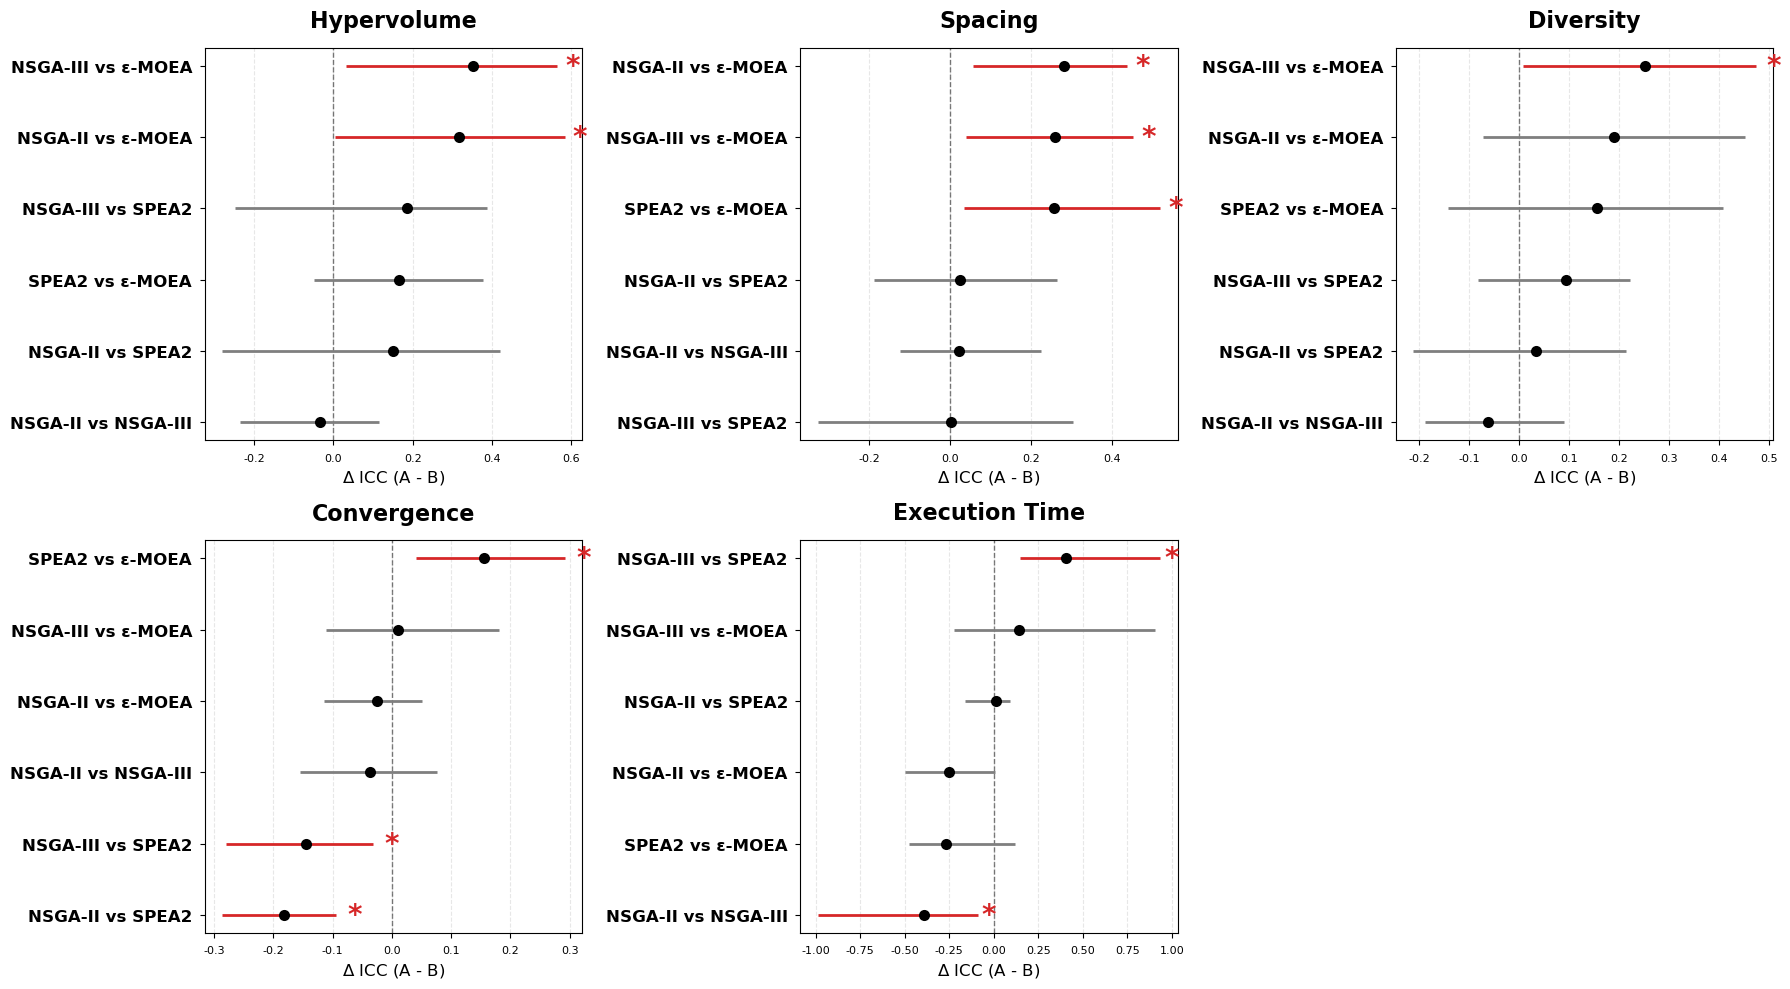

In [44]:
import math
def plot_significance_forest_optimized(data: pd.DataFrame, save_path: str = None):
    metrics = data['Metric'].unique()
    n_metrics = len(metrics)
    n_cols = math.ceil(n_metrics / 2)    
    fig, axes = plt.subplots(2, n_cols, figsize=(6 * n_cols, 10))
    axes_flat = axes.flatten() # 2차원 배열을 1차원으로 펴서 접근
    
    for i, metric in enumerate(metrics):
        ax = axes_flat[i]
        subset = data[data['Metric'] == metric].copy()
        
        val_col = 'ICC Difference (Mean)' if 'ICC Difference (Mean)' in subset.columns else 'ICC Difference'
        subset = subset.sort_values(val_col, ascending=True)        
        ax.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        
        for j, (idx, row) in enumerate(subset.iterrows()):
            color = '#d62728' if row['Significant'] else '#7f7f7f'
            val = row[val_col]
            xerr_low = val - row['CI_Lower']
            xerr_high = row['CI_Upper'] - val
            
            ax.errorbar(val, j, 
                        xerr=[[xerr_low], [xerr_high]], 
                        fmt='o', color='black', ecolor=color, 
                        capsize=5, elinewidth=2, markersize=8)
            
            if row['Significant']:
                ax.text(row['CI_Upper'] + 0.02, j, '*', va='center', ha='left', 
                       fontsize=20, color='#d62728', fontweight='bold')

        ax.set_yticks(np.arange(len(subset)))
        ax.set_yticklabels(subset['Comparison'], fontsize=12, fontweight='bold')
        ax.set_title(f'{metric}', fontsize=16, fontweight='bold', pad=15)
        ax.set_xlabel('$\Delta$ ICC (A - B)', fontsize=12)
        ax.grid(True, axis='x', linestyle='--', alpha=0.3)

    for k in range(i + 1, len(axes_flat)):
        axes_flat[k].axis('off')

    plt.tight_layout()
    
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

plot_significance_forest_optimized(combined_paired_df, os.path.join(OUTPUT_DIR, 'figures', 'figure2_icc_forest_plot.png'))